# Accelerating a Python script
Sometimes a script in plain python is still too slow. This can occur when you have a model that repeats a computation over a large grid, and then again iterates this in time. This can easily lead to millions of iterations of the same computation during a model run. 

Python is an interpreter, meaning that you code is read, interpreted and executed line by line. Despite the optimization that Python does, this is still a time-consuming process. A compiled language such a C++ or Fortran would always be faster.

There are a number of approaches to translate or replace Python code with blocks of compiled code. In this lecture, we will discuss:
- Numba: A package that translate python code to C++ when a model is run
- Cython: A package that translates python to C++ code
- Ctypes : A packages that allows integration of C++ code within Python
- PyOpenCL: A packages that allows you to have code executed on the GPU.

The code below is cleverly copied from https://ipython-books.github.io/52-accelerating-pure-python-code-with-numba-and-just-in-time-compilation/

# Our example system: the Mandelbrot fractal

<img src="https://upload.wikimedia.org/wikipedia/commons/2/21/Mandel_zoom_00_mandelbrot_set.jpg" width="650" align="left" />

# The Mandelbrot fractal computed in Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

size = 400
iterations = 100
a=-2

m = np.zeros((size, size))

In [2]:
def mandelbrot_python(size, iterations):
    m = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            c = (a + 3. / size * j + 1j * (1.5 - 3. / size * i))
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break
    return m

In [3]:
Standard = %timeit -o -r1 mandelbrot_python(size, iterations)

6.19 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


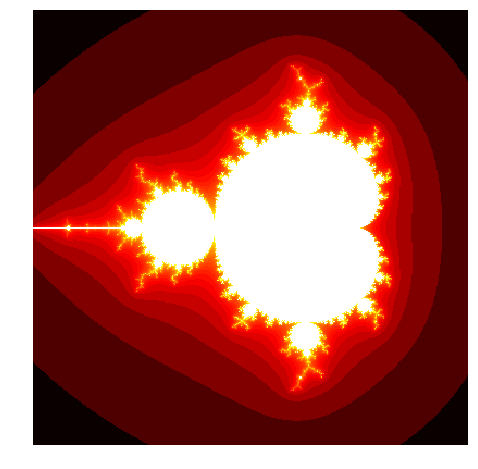

In [4]:
m = mandelbrot_python(size, iterations)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(np.log(m), cmap=plt.cm.hot)
ax.set_axis_off()

# Accelerating with Numba



Numba compiles Python code into C++ when you run the code, speeding up the execution of the code. Numba can generate serial code, but can also parallelize to using multiple code. Code needs to be prepared for this, because

<img src="Images/Numba.png" width="650" align="left" /> 

In [5]:
import numba
from numba import jit, complex128

In [6]:
@jit
def mandelbrot_numba(size, iterations):
    m = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            c = (a + 3. / size * j + 1j * (1.5 - 3. / size * i))
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break
    return m

In [7]:
NumbaRes = %timeit -o m=mandelbrot_numba(size, iterations)
print('Acceleration using numba compared to looped version: %1.0f times.' % (Standard.best/NumbaRes.best))

22.2 ms ± 418 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Acceleration using numba compared to looped version: 288 times.


# An unfair comparison: what about numpy?

In [8]:
def mandelbrot_matrix(size, iterations):
    m = size
    n = size
 
    x = np.linspace(-2, 1, num=m).reshape((1, m))
    y = np.linspace(-1.5, 1.5, num=n).reshape((n, 1))
    C = np.tile(x, (n, 1)) + 1j * np.tile(y, (1, m))
 
    Z = np.zeros((n, m), dtype=complex)
    R = np.zeros((n, m))
    M = np.full((n, m), True, dtype=bool)
    for i in range(iterations):
        Z[M] = Z[M] * Z[M] + C[M]
        M[np.abs(Z) >= 10] = False
        R[np.abs(Z) >= 10] = i
        Z[np.abs(Z) >= 10] = 0  
        
    R[R==0 ] = iterations        
        
    return R  

In [9]:
Numpy = %timeit -o mandelbrot_matrix(size, iterations)
print('Acceleration with Numba vs matrix: %1.0f times.' % (Numpy.best / NumbaRes.best))

447 ms ± 132 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Acceleration with Numba vs matrix: 14 times.


# And now really in parallel

Using Numba, you can also use multiple cores at the same time to compute your calculation. This is called Parallel computing.

In [10]:
from numba import njit, prange

@njit(parallel=True)
def mandelbrot_numba_par(size, iterations):
    m = np.zeros((size, size))
    for i in prange(size):
        for j in prange(size):
            c = (a + 3. / size * j + 1j * (1.5 - 3. / size * i))
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break
    return m

In [11]:
Numba_par = %timeit -o mandelbrot_numba_par(size, iterations)
print('Acceleration - numba parallel vs looped: %1.0f times.' % (Standard.best/Numba_par.best))
print('Acceleration - numba parallel vs matrix: %1.0f times.' % (Numpy.best/Numba_par.best))

7.9 ms ± 568 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Acceleration - numba parallel vs looped: 885 times.
Acceleration - numba parallel vs matrix: 44 times.


# Cython: generating a before-hand compiled function

In [12]:
%load_ext cython

In [13]:
%%cython
import numpy as np

def mandelbrot_cython(m, size, iterations):
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

## How fast is Cython?

In [ ]:
s = (size, size)
m = np.zeros(s, dtype=np.int32)

In [14]:
Cython_Res1 = %timeit -n1 -r1 -o mandelbrot_cython(m, size, iterations)
print('Acceleration - Cython vs looped: %1.0f times.' % (Standard.best/Cython_Res1.best))

7.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Acceleration - Cython vs looped: 1 times.


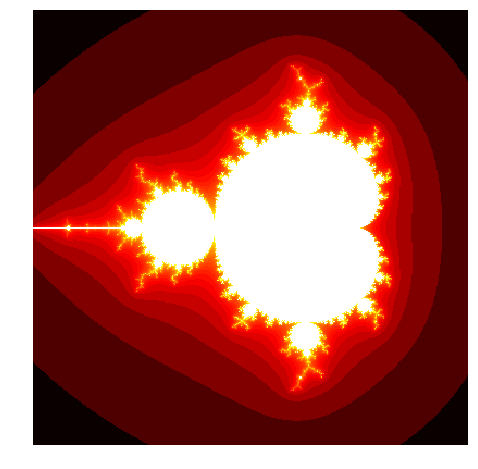

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(np.log(m), cmap=plt.cm.hot)
ax.set_axis_off()

## Optimizing Cython by explicit variable definitions

In [27]:
%%cython
import numpy as np

def mandelbrot_cython2(int[:,::1] m, int size, int iterations):
    cdef int i, j, n
    cdef complex z, c
    for i in range(size):
        for j in range(size):
            c = -2. + 3./size*j + 1j*(1.5-3./size*i)
            z = 0.
            for n in range(iterations):
                if z.real**2 + z.imag**2 <= 100:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [17]:
s = (size, size)
m = np.zeros(s, dtype=np.int32)
Cython_Res2 = %timeit -o mandelbrot_cython2(m, size, iterations)
print('Acceleration - Cython perfected vs looped: %1.0f times.' % (Standard.best/Cython_Res2.best))

14.7 ms ± 341 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Acceleration - Cython perfected vs looped: 429 times.


# Integrating C++ code with Ctypes

In [18]:
%%writefile mandelbrot.c
#include "stdio.h"
#include "stdlib.h"

void mandelbrot(int size, int iterations, int *col)
{
    // Variable declarations.
    int i, j, n, index;
    double cx, cy;
    double z0, z1, z0_tmp, z0_2, z1_2;

    // Loop within the grid.
    for (i = 0; i < size; i++)
    {
        cy = -1.5 + (double)i / size * 3;
        for (j = 0; j < size; j++)
        {
            // We initialize the loop of the system.
            cx = -2.0 + (double)j / size * 3;
            index = i * size + j;
            // Let's run the system.
            z0 = 0.0;
            z1 = 0.0;
            for (n = 0; n < iterations; n++)
            {
                z0_2 = z0 * z0;
                z1_2 = z1 * z1;
                if (z0_2 + z1_2 <= 100)
                {
                    // Update the system.
                    z0_tmp = z0_2 - z1_2 + cx;
                    z1 = 2 * z0 * z1 + cy;
                    z0 = z0_tmp;
                    col[index] = n;
                }
                else
                {
                    break;
                }
            }
        }
    }
}

Overwriting mandelbrot.c


In [19]:
!!gcc -shared -o mandelbrot.so -fPIC mandelbrot.c

[]

In [20]:
import ctypes
lib = ctypes.CDLL('mandelbrot.so')
mandelbrot = lib.mandelbrot

In [21]:
from numpy.ctypeslib import ndpointer
# Define the types of the output and arguments of
# this function.
mandelbrot.restype = None
mandelbrot.argtypes = [ctypes.c_int,
                       ctypes.c_int,
                       ndpointer(ctypes.c_int),
                       ]

# Speedup with C++ code with Ctype

In [22]:
import numpy as np
# We initialize an empty array.
size = 400
iterations = 100
col = np.empty((size, size), dtype=np.int32)
# We execute the C function, which will update the array.
Ctypes_Res = %timeit -o mandelbrot(size, iterations, col)
print('Acceleration - Cython perfected vs looped: %1.0f times.' % (Standard.best/Ctypes_Res.best))

30.4 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Acceleration - Cython perfected vs looped: 216 times.


# Running a real spatial model

I have prepared various versions of Chris Klausmeier's arid vegetation patterns model (a classic self-organization model), with versions for `Nump`, `Numba`, `Numba parallel`, `Cython`, `Ctypes`, and `PyOpenCl`. 

In [23]:
def RunSim(EndTime, dt):
    
    # We simulate the PDE with the finite difference method.
    for count in range(NumPlots):    
        for rep in range(int(EndTime/ dt / NumPlots)):
            # We update the variables.
            W, N = \
                W + dt * ( a - W - W*N*N - v*d_dy(W) + dw * d2_dxy2(W)),\
                N + dt * ( W*N*N - m*N + dn * d2_dxy2(N))

            # We store the state of the system for NumPlot different times.
            Ns[:,:,count] = N

    return Ns        

### Unwinding the Klausmeier model

In [24]:
@njit(parallel=True)
def SimulationKernel(W,N):
    for rep in range(int(EndTime/ dt / NumPlots)):
        for x in prange(Grid_Width):
            for y in prange(Grid_Height):
                # The computations applied to the grid
                if (x>0) and (x<(Grid_Width-1)) and (y>0) and (y<(Grid_Height-1)):
                    Cons = W[x,y]*N[x,y]*N[x,y]
                    dW = ( a - W[x,y] - Cons - v * d_dy(W,x,y) + dw * d2_dxy2(W,x,y) )
                    dN = ( Cons - m*N[x,y] + dn * d2_dxy2(N,x,y) )
                    W[x,y] = W[x,y] + dt * dW
                    N[x,y] = N[x,y] + dt * dN 
                else: 
                    PeriodicBoundaries(W,x,y)
                    PeriodicBoundaries(N,x,y) 

## Examples on the dropbox
### Folder: Accelerating

`Accelerating the Mandelbrot fractal - 1 Numba.ipynb`  
`Accelerating the Mandelbrot fractal - 2 Cython.ipynb`  
`Accelerating the Mandelbrot fractal - 3 ctypes.ipynb`     

`Accelerating Arid vegetation patterns - 1 Standard model.ipynb`  
`Accelerating Arid vegetation patterns - 2 Numba.ipynb`  
`Accelerating Arid vegetation patterns - 3 Cython.ipynb`  
`Accelerating Arid vegetation patterns - 4 ctypes.ipynb`  
`Accelerating Arid vegetation patterns - 5 PyOpenCL.ipynb`  

# A comparison - Including R and Matlab

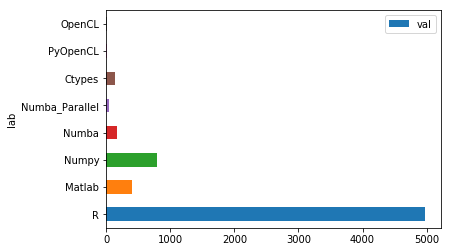

In [25]:
import pandas as pd

df = pd.DataFrame({'lab':['R', 'Matlab', 'Numpy', 'Numba', 'Numba_Parallel', 'Ctypes', 'PyOpenCL', 'OpenCL'], 
                   'val':[4976  , 402     ,    786,    166,             41.8,      142,       10.7,    6.59]})
ax = df.plot.barh(x='lab', y='val', rot=0)

# A comparison - Python only

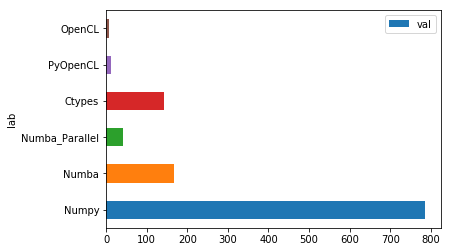

In [26]:
df = pd.DataFrame({'lab':['Numpy', 'Numba', 'Numba_Parallel', 'Ctypes', 'PyOpenCL', 'OpenCL'], 
                   'val':[    786,    166,             41.8,      142,       10.7,    6.59]})
ax = df.plot.barh(x='lab', y='val', rot=0)

# Computing on the NIOZ Cluster
The NIOZ has a compute cluster, consisting of :  
- 14 Xeon processors with 40 cores each  
- 1 Nvidia Tesla P100 GPU processor with 3584 cores  

Normal Compute node: laplace.nioz.nl  
GPU compute node: tesla.nioz.nl  

There are also older cluster nodes and nodes specialized for Bioinformatics. For an overview, see: http://laplace.nioz.nl/HPC/  

To log in, enter in terminal:  
`ssh -CX DonaldT@laplace.nioz.nl`   
`ssh -CX DonaldT@tesla.nioz.nl`  
insert your own name and enter your password (you need to get one).   

Please use Laplace if you are not using the GPU.  
To ask for an account, email: Hans.Malschaert@nioz.nl  

# Running Jupyter on the NIOZ cluster:

Enter in the terminal:  
`jupyter notebook --no-browser --ip="*"`   

Then, copy the URL appearing on screen from the terminal, and copy it in the browser. If you are not at NIOZ, use the VPN, and change "no74" into "no74.nioz.nl". Voila!  

Now a standard Jupyter notebook interface opens, and use as normal.   

To transfer files from computer to cluster:
- Mac OS: e.g. FileZilla, Cyberduck, Coda
- Windows: MobaXterm

## Challenges
- Make your model in Numba
- Make your model in PyOpenCL or PyCUDA (C++ knowledge benefitial)
- Implement your model on the cluster
- Make a nice-looking fractal, preferably animated
- Continue with an old assignment

Cleverly copied from https://ipython-books.github.io/52-accelerating-pure-python-code-with-numba-and-just-in-time-compilation/